In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage
from scipy.optimize import least_squares
from skimage.draw import draw
from scipy import interpolate
import copy
import pickle

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

### Model the PSD
Base the model on the average PSD.

In [2]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 0.050*u.m, # not really useful but okay
             'surf_units': u.micron,
             'ring_width': 5,
             'kmid_ll': 100 * u.m,
             'khigh_ll': 1000 * u.m,
             'label': 'oap'}

fileloc = 'zygo_data/oaps/oap_coated/oap_avgPSD_centered_{0}CA_meters.fits'.format(str(opt_parms['ca']))
psd_fits = fits.open(fileloc)[0]
psd_avg = psd_fits.data * (u.nm*u.m)**2
psd_hdr = psd_fits.header
opt_parms['dk'] = (psd_hdr['delta_k']/u.m)
opt_parms['diam_ca'] = (psd_hdr['diam_ca']*u.m)
opt_parms['diam_pix'] = psd_hdr['diam_pix']
opt_parms['wavelen'] = psd_hdr['wavelen'] * u.m

# calculate the radial PSD data
avg_psd = psd.surfPSD(surf_name='average PSD')
avg_psd.load_psd(psd_data=psd_avg, psd_type='cal')
avg_psd.load_psd_parameters(diam_ca=opt_parms['diam_ca'], npix_diam=opt_parms['diam_pix'],
                            wavelen=opt_parms['wavelen'], delta_k=opt_parms['dk'])
avg_psd.calc_psd_radial(ring_width=opt_parms['ring_width'], kmin=avg_psd.k_min)
avg_psd.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'],
                     pwr_opt=avg_psd.psd_cal, print_rms=True, print_kloc=False)

Target range - k_low: 23.398 1 / m and k_high: 9579.277 1 / m
RMS value: 7.8133 nm
Target range - k_low: 23.398 1 / m and k_high: 98.273 1 / m
RMS value: 4.0342 nm
Target range - k_low: 98.273 1 / m and k_high: 1001.449 1 / m
RMS value: 4.9889 nm
Target range - k_low: 1001.449 1 / m and k_high: 9579.277 1 / m
RMS value: 4.4591 nm
Target range - k_low: 98.273 1 / m and k_high: 9579.277 1 / m
RMS value: 6.6913 nm
CPU times: user 2min 33s, sys: 55.8 s, total: 3min 29s
Wall time: 3min 29s


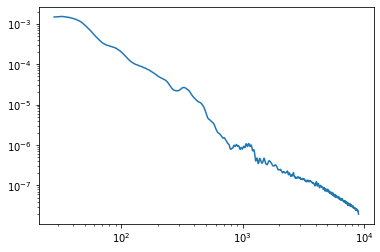

In [3]:
# Throw away some of the high-k ending data for better fitting
# The last data doesn't seem critical anyways
fin = len(avg_psd.k_radial)
offset = 120
avg_psd.k_radial = avg_psd.k_radial[0:fin-offset]
avg_psd.psd_radial_cal = avg_psd.psd_radial_cal[0:fin-offset]
#plt.loglog(avg_psd.k_radial[0:fin-offset].value, avg_psd.psd_radial_cal[0:fin-offset].value)
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value)

In [4]:
def calc_model_rms(avg_psd, mdl_set):
    delta_k = avg_psd.delta_k
    npix_diam = avg_psd.npix_diam
    # build the k-map
    cen = int(npix_diam/2)
    if npix_diam%2 == 0:
        ky, kx = np.ogrid[-cen:cen, -cen:cen]
    else:
        ky, kx = np.ogrid[-cen:cen+1, -cen:cen+1]
    ky = ky*delta_k
    kx = kx*delta_k
    k_map = np.sqrt(kx**2 + ky**2)
    
    # calculate the PSD
    psd_mdl = np.zeros_like(k_map.value)
    for n in range(0, len(mdl_set)):
        psd_parm = [mdl_set[n].alpha, mdl_set[n].beta, mdl_set[n].L0, mdl_set[n].lo, mdl_set[n].bsr]
        nmdl_psd = psd.model_full(k=k_map, psd_parm=psd_parm).value * mdl_set[n].psd_weight
        psd_mdl = psd_mdl + nmdl_psd
    psd_sum = psd_mdl * avg_psd.psd_radial_cal.unit
    
    # with the PSD calculated, do the RMS
    k_tgt_lim = [avg_psd.k_min, avg_psd.k_max]
    psd_rms = psd.do_psd_rms(psd_data=psd_sum, delta_k=delta_k, 
                             k_tgt_lim=k_tgt_lim, print_rms=False, print_kloc=False)
    return psd_rms


def plot_model2(mdl_set, model_sum, err_ratio, avg_psd, opt_parms):
    k_radial = avg_psd.k_radial.value
    psd_radial = avg_psd.psd_radial_cal.value
    k_range_mdl = mdl_set[0].k_range.value
    
    mdl_rms = calc_model_rms(avg_psd, mdl_set)
    
    color_list=['r', 'b','y', 'g']
    anno_opts = dict(xy=(0.1, .9), xycoords='axes fraction',
                     va='center', ha='center')

    plt.figure(figsize=[14,9],dpi=100)
    gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])
    ax0 = plt.subplot(gs[0])  
    ax0.loglog(k_radial, psd_radial, 'k', linewidth=3, label='Avg PSD (PTT, all steps)\nRMS={0:.3f}'.format(avg_psd.rms_tot))
    for j in range(0, len(mdl_set)):
        if mdl_set[j].psd_weight != 0: 
            plt_label = '{0}: {1}={2:.3f} {3}={4:.3e}\n'.format(r'$r_{0}$'.format(mdl_set[j].region_num),
                                                                 r'$\alpha$', mdl_set[j].alpha, 
                                                                 r'$\beta$', mdl_set[j].beta.value)
            plt_label = plt_label + '{0}={1:.1e}, {2}={3:.2e}, {4}={5:.1e}A\n'.format(r'$L_{0}$',mdl_set[j].L0, 
                                                                                       r'$l_{0}$', mdl_set[j].lo, 
                                                                                       r'$\sigma_{sr}$', mdl_set[j].rms_sr.to(u.angstrom).value)
            plt_label = plt_label + '{0}={1:.2f}'.format(r'$a_{0}$'.format(j), mdl_set[j].psd_weight)
            ax0.loglog(mdl_set[j].k_range.value, mdl_set[j].psd_full_scaled.value, color_list[j]+':', linewidth=1.5,
                       label=plt_label)
            # draw in the color box
            ax0.axvspan(k_radial[mdl_set[j].i_start], k_radial[mdl_set[j].i_end], facecolor=color_list[j], alpha=0.1)
    mdl_sum_text = 'model sum {0}\nRMS={1:.3f}'.format(r'$\Sigma a_{n}r_{n}$', mdl_rms)
    ax0.loglog(k_range_mdl, model_sum.value, linewidth=2.5, label=mdl_sum_text)
    ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
    ax0.set_ylim(bottom=1e-10)
    ax0.set_ylabel('PSD ({0})'.format(mdl_set[0].psd_full.unit))
    ax0.legend(prop={'size':8})#,loc='center left', bbox_to_anchor=(1, 0.5))
    ax0.set_title('MagAO-X PSD modeling (PRELIMINARY VISUAL): {0}, {1}% CA'.format(opt_parms['label'], opt_parms['ca']))
    
    #avg_err = np.mean(np.abs(err_ratio))
    err_rms = np.sqrt(np.mean(np.square(err_ratio)))
    ax1 = plt.subplot(gs[1])
    ax1.semilogx(k_radial, err_ratio)
    ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k')
    ax1.set_ylim(top=1, bottom=-1)
    ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
    ax1.set_ylabel('log(ratio error)')
    ax1.set_xlabel('Spatial Frequency [{0}]'.format(mdl_set[0].k_range.unit))
    ax1.annotate('Error RMS: {0:.4}'.format(err_rms), **anno_opts)

    plt.tight_layout()

/home/jhen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


CPU times: user 20.6 s, sys: 223 ms, total: 20.8 s
Wall time: 10.7 s


/home/jhen/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jhen/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


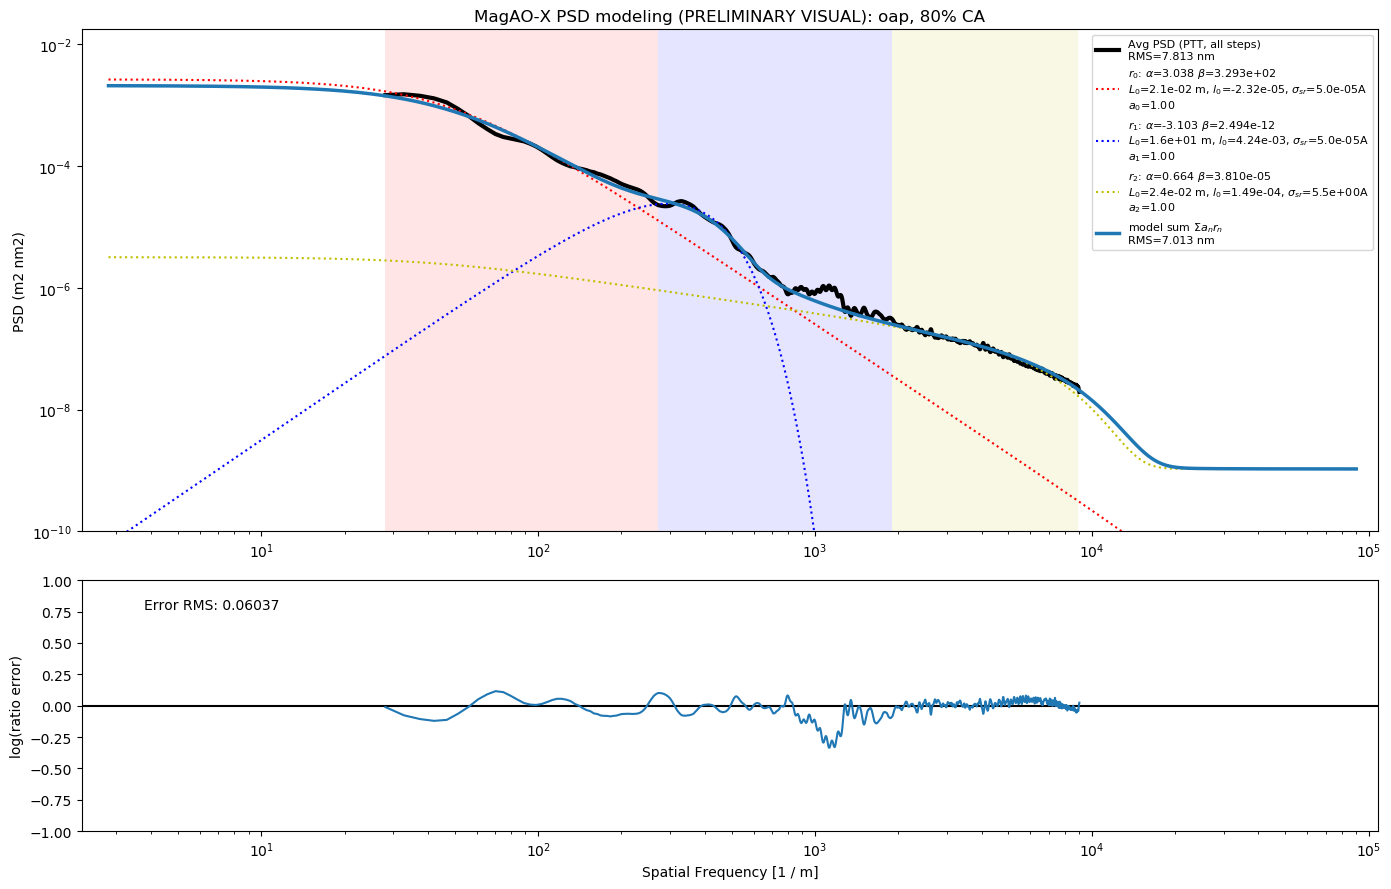

In [5]:
%%time
ist = [0, 52, 400]
#iend = [30, 390]
iend = ist[1:]
iend.append(len(avg_psd.k_radial)-15)

sr_rms = [0.51, 0.54, 1.00, 0.59, 0.5, 0.41, 0.44, 0.43] * u.nm
avg_sr_rms = np.mean(sr_rms)
rms_sr = [0.000005*u.nm,0.000005*u.nm, avg_sr_rms]

psd_weight = [1.0, 1.0, 1.0]
k_limit = [np.amin(avg_psd.k_radial)/10, np.amax(avg_psd.k_radial)*10]
mdl_set = []
x0 = [[1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-4, 1.0e-4, 1.0e-4, 1.0e-4]]
for j in range(0, len(ist)):
    mdl = psd.model_single(region_num=j)
    mdl.load_data(ind_range=[ist[j],iend[j]], psd_obj=avg_psd)
    mdl.calc_psd_parm(rms_sr=rms_sr[j], x0=x0[j])#, ratio_mode=False)
    mdl.calc_model_total(psd_weight=psd_weight[j], k_spacing=opt_parms['dk']*0.2, k_limit=k_limit)
    mdl_set.append(mdl)

# model sum evaluation
ms = psd.model_combine(mdl_set=mdl_set, avg_psd=avg_psd)
ms.calc_error()
ms.calc_psd_rms()

# model sum with a total refit
ms_refit = psd.model_combine(mdl_set=mdl_set, avg_psd=avg_psd)
ms_refit.calc_refit()
ms_refit.calc_error()
ms_refit.calc_psd_rms()

plot_model2(mdl_set, ms_refit.psd_radial_sum, ms_refit.error, avg_psd, opt_parms)

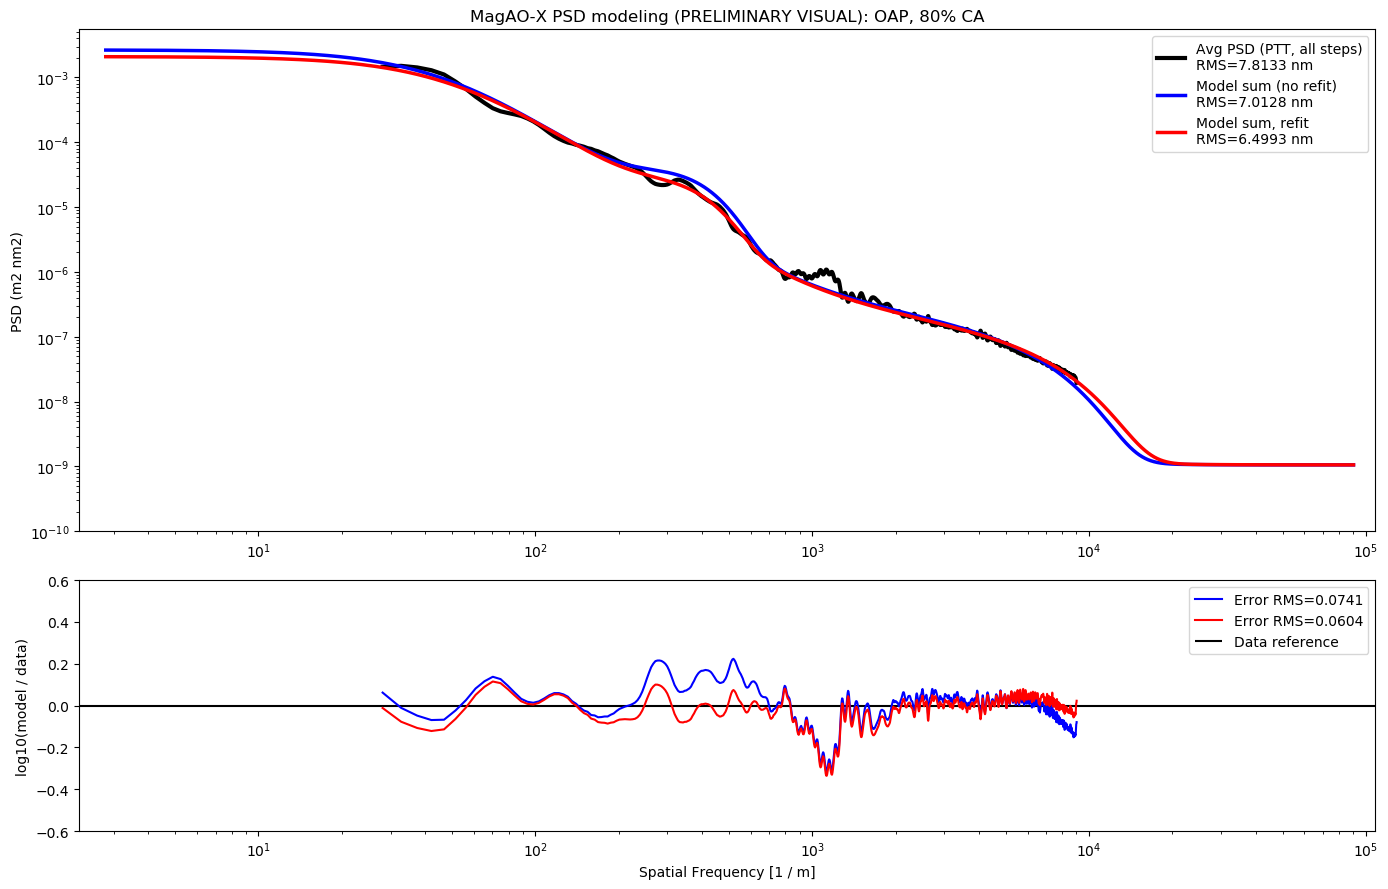

In [6]:
k_radial = avg_psd.k_radial.value
psd_radial = avg_psd.psd_radial_cal.value
k_range_mdl = mdl_set[0].k_range.value

plt.figure(figsize=[14,9],dpi=100)
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])
ax0 = plt.subplot(gs[0])  
ax0.loglog(k_radial, psd_radial, 'k', linewidth=3, label='Avg PSD (PTT, all steps)\nRMS={0:.4f}'.format(avg_psd.rms_tot))
ax0.loglog(k_range_mdl, ms.psd_radial_sum.value, 'b', linewidth=2.5, label='Model sum (no refit)\nRMS={0:.4f}'.format(ms.psd_rms_sum))
ax0.loglog(k_range_mdl, ms_refit.psd_radial_sum.value, 'r', linewidth=2.5, label='Model sum, refit\nRMS={0:.4f}'.format(ms_refit.psd_rms_sum))
ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax0.set_ylim(bottom=1e-10)
ax0.set_ylabel('PSD ({0})'.format(ms.psd_radial_sum.unit))
ax0.legend(prop={'size':10})#,loc='center left', bbox_to_anchor=(1, 0.5))
ax0.set_title('MagAO-X PSD modeling (PRELIMINARY VISUAL): OAP, {0}% CA'.format(opt_parms['ca']))

#avg_err = np.mean(np.abs(err_ratio))
ax1 = plt.subplot(gs[1])
ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k', label='Data reference')
ax1.semilogx(k_radial, ms.error, 'b', label='Error RMS={0:.4f}'.format(ms.error_rms))
ax1.semilogx(k_radial, ms_refit.error, 'r', label='Error RMS={0:.4f}'.format(ms_refit.error_rms))
ax1.legend(prop={'size':10})
ax1.set_ylim(top=0.6, bottom=-0.6)
ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax1.set_ylabel('log10(model / data)')
ax1.set_xlabel('Spatial Frequency [{0}]'.format(ms.k_radial_data.unit))
#ax1.annotate('Mean abs error %: {0:.4}%'.format(avg_err), **anno_opts)

plt.tight_layout()

Text(0.5, 1.0, 'MagAO-X PSD modeling (PRELIMINARY VISUAL): OAP, 80% CA')

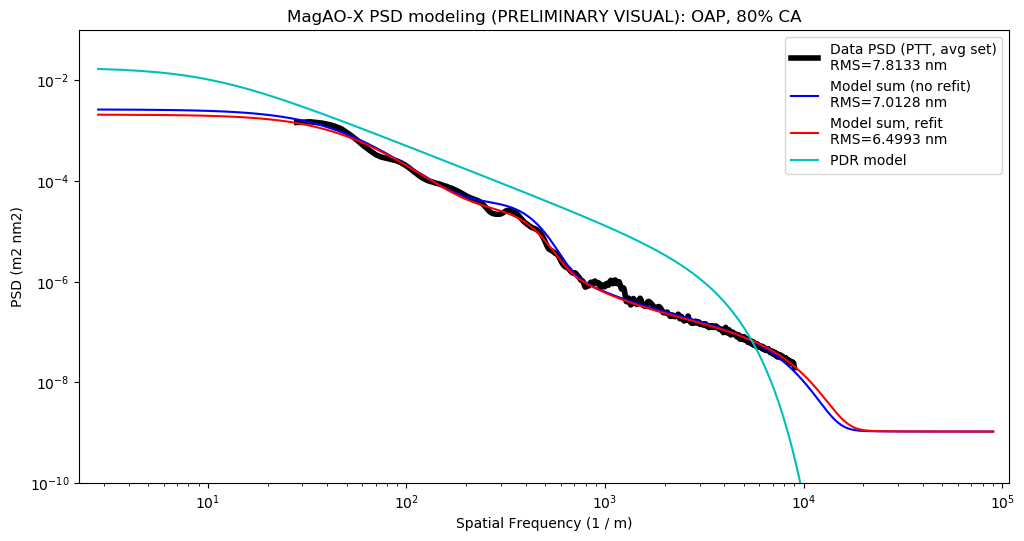

In [7]:
ap = 1.55
bp = 0.637 * (u.nm**2)/(u.m**(ap-2))
parm_pdr = [ap, bp, 0.1*u.m, 0.0003, 0*(u.nm*u.m)**2]
psd_pdr = psd.model_full(k=mdl_set[0].k_range, psd_parm=parm_pdr)

k_radial = avg_psd.k_radial.value
psd_radial = avg_psd.psd_radial_cal.value
k_range_mdl = mdl_set[0].k_range.value

plt.figure(figsize=[12,6],dpi=100)
plt.loglog(k_radial, psd_radial, 'k', linewidth=4, label='Data PSD (PTT, avg set)\nRMS={0:.4f}'.format(avg_psd.rms_tot))
plt.loglog(k_range_mdl, ms.psd_radial_sum.value, 'b', linewidth=1.5, label='Model sum (no refit)\nRMS={0:.4f}'.format(ms.psd_rms_sum))
plt.loglog(k_range_mdl, ms_refit.psd_radial_sum.value, 'r', linewidth=1.5, label='Model sum, refit\nRMS={0:.4f}'.format(ms_refit.psd_rms_sum))
plt.loglog(k_range_mdl, psd_pdr.value, 'c', linewidth=1.5, label='PDR model')
plt.xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
plt.ylim(top=0.1, bottom=1e-10)
plt.ylabel('PSD ({0})'.format(ms.psd_radial_sum.unit))
plt.xlabel('Spatial Frequency ({0})'.format(mdl_set[0].k_range.unit))
plt.legend(prop={'size':10})#,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('MagAO-X PSD modeling (PRELIMINARY VISUAL): OAP, {0}% CA'.format(opt_parms['ca']))

Text(0.5, 1.0, 'PSD oap, RMS=7.0130 nm, PV=60.74 nm')

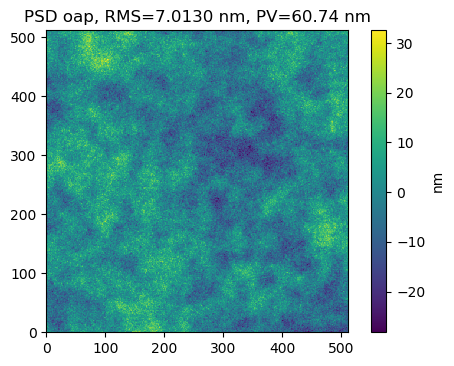

In [10]:
psd_weight_oap = [1.0, 1.0, 1.0]

screen_size = 2048
seed = 5 #123456
npix = 512
diam = 0.02587875072 * u.m
surf_unit = u.nm

def rms(opd):
    return np.sqrt(np.mean(np.square(opd)))

def pv(opd):
    return np.amax(opd) - np.amin(opd)

import poppy
psd_wave = poppy.poppy_core.Wavefront(npix=npix, diam=diam, wavelength=656e-9)
psd_wfe = poppy.wfe.PowerSpectrumWFE(psd_parameters=ms_refit.psd_parm, psd_weight=psd_weight_oap,
                                seed=seed, apply_reflection=False, screen_size=screen_size,
                                wfe=7.013*u.nm)
psd_opd = ((psd_wfe.get_opd(psd_wave))*u.m).to(surf_unit)
psd_rms = rms(psd_opd)
psd_pv = pv(psd_opd)

plt.figure(dpi=100)
plt.imshow(psd_opd.value, origin='lower')
plt.colorbar().set_label(psd_opd.unit)
plt.title('PSD oap, RMS={0:.4f}, PV={1:.2f}'.format(psd_rms, psd_pv))

In [ ]:
psd_parm = []
for j in range(0, len(mdl_set)):
    parameters = [mdl_set[j].alpha, mdl_set[j].beta, mdl_set[j].L0, mdl_set[j].lo, mdl_set[j].bsr]
    psd_parm.append(parameters)
    
psd_dict = {'psd_oap': psd_parm,
            'psd_oap_weight': psd_scl[0]}

# save the directory as a pickle
filename='/home/jhen/XWCL/code/MagAOX/PSD/psd_parms_oap.pickle'
with open(filename,'wb') as psd_parameter_file:
    pickle.dump(psd_dict, psd_parameter_file, protocol=4)
    
objects = []
with (open("/home/jhen/XWCL/code/MagAOX/PSD/psd_parms_oap.pickle", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
            
objects

Old Analysis with nm2 mm2 = do not delete (yet)

/home/jhen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/jhen/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jhen/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


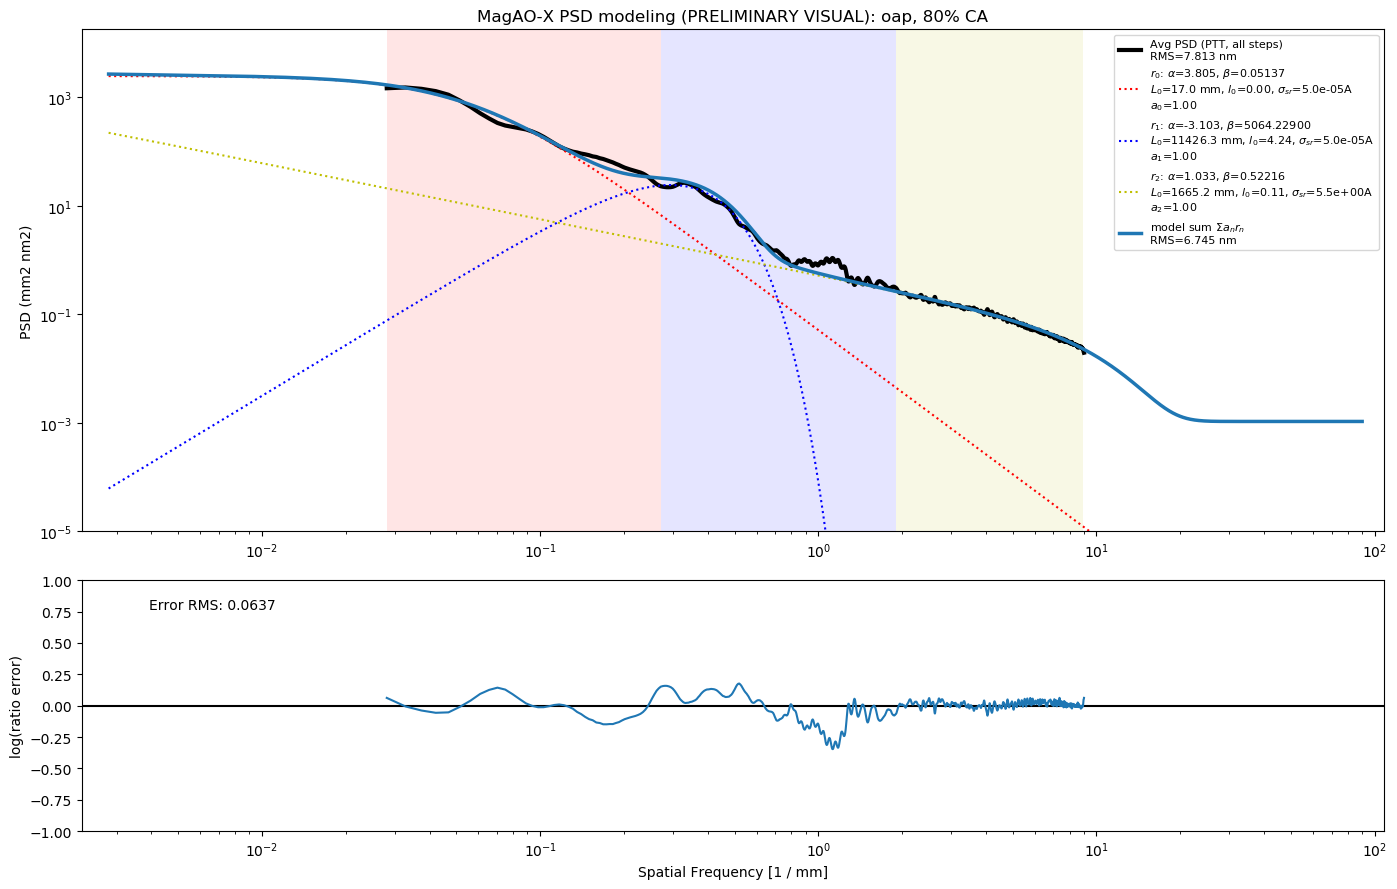

In [5]:
ist = [0, 52, 400]
#iend = [30, 390]
iend = ist[1:]
iend.append(len(avg_psd.k_radial)-15)

sr_rms = [0.51, 0.54, 1.00, 0.59, 0.5, 0.41, 0.44, 0.43] * u.nm
avg_sr_rms = np.mean(sr_rms)
rms_sr = [0.000005*u.nm,0.000005*u.nm, avg_sr_rms]

psd_weight = [1.0, 1.0, 1.0]
k_limit = [np.amin(avg_psd.k_radial)/10, np.amax(avg_psd.k_radial)*10]
mdl_set = []
for j in range(0, len(ist)):
    mdl = psd.model_single(region_num=j)
    mdl.load_data(ind_range=[ist[j],iend[j]], psd_obj=avg_psd)
    mdl.calc_psd_parm(rms_sr=rms_sr[j])#, ratio_mode=False)
    mdl.calc_model_total(psd_weight=psd_weight[j], k_spacing=opt_parms['dk']*0.2, k_limit=k_limit)
    mdl_set.append(mdl)

# model sum evaluation
ms = psd.model_combine(mdl_set=mdl_set, avg_psd=avg_psd)
ms.calc_error()
ms.calc_psd_rms()

# model sum with a total refit
ms_refit = psd.model_combine(mdl_set=mdl_set, avg_psd=avg_psd)
ms_refit.calc_refit()
ms_refit.calc_error()
ms_refit.calc_psd_rms()

plot_model2(mdl_set, ms.psd_radial_sum, ms.error, avg_psd, opt_parms)

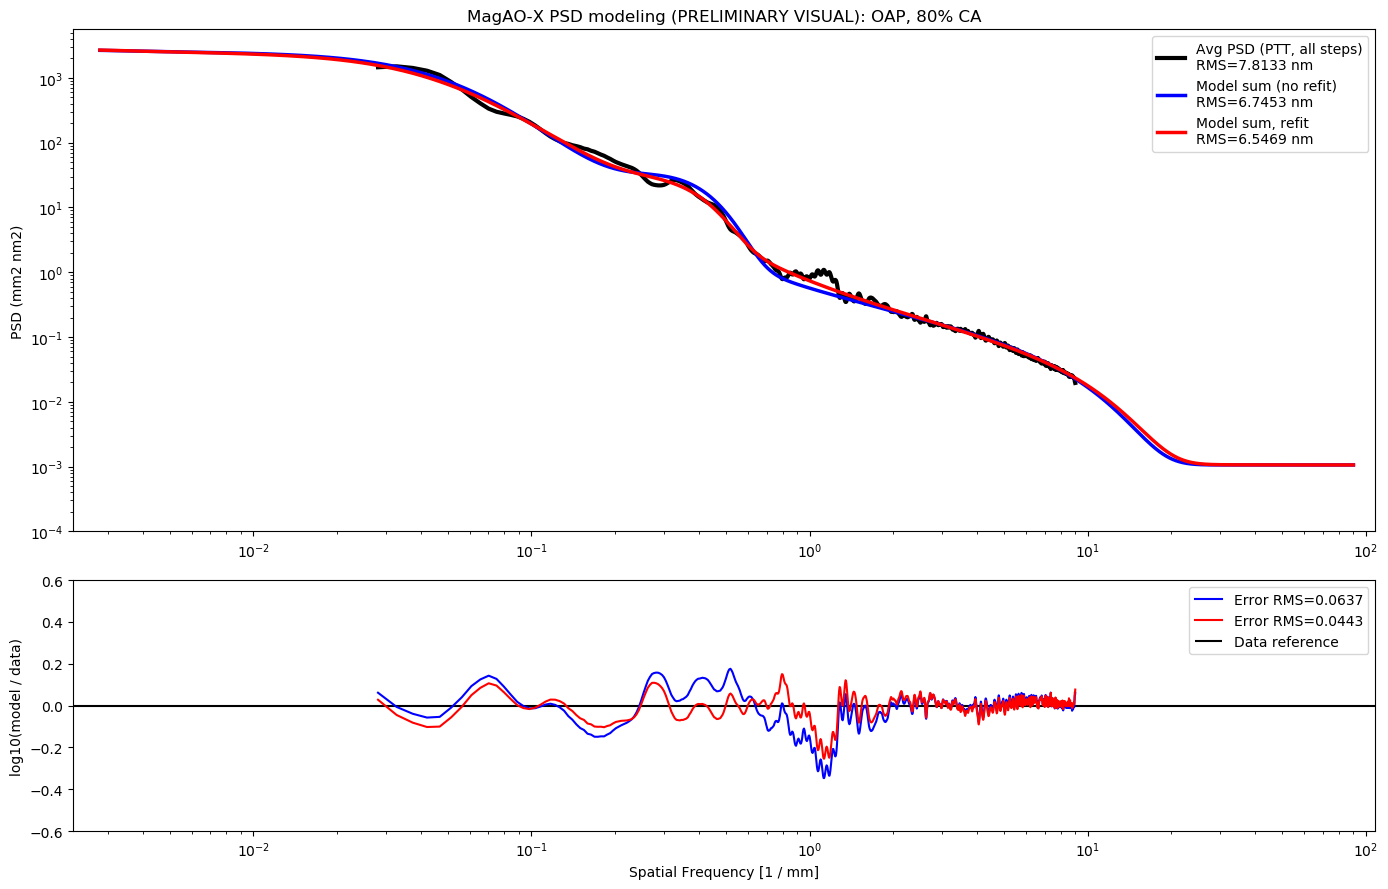

In [70]:
k_radial = avg_psd.k_radial.value
psd_radial = avg_psd.psd_radial_cal.value
k_range_mdl = mdl_set[0].k_range.value

plt.figure(figsize=[14,9],dpi=100)
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])
ax0 = plt.subplot(gs[0])  
ax0.loglog(k_radial, psd_radial, 'k', linewidth=3, label='Avg PSD (PTT, all steps)\nRMS={0:.4f}'.format(avg_psd.rms_tot))
ax0.loglog(k_range_mdl, ms.psd_radial_sum.value, 'b', linewidth=2.5, label='Model sum (no refit)\nRMS={0:.4f}'.format(ms.psd_rms_sum))
ax0.loglog(k_range_mdl, ms_refit.psd_radial_sum.value, 'r', linewidth=2.5, label='Model sum, refit\nRMS={0:.4f}'.format(ms_refit.psd_rms_sum))
ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax0.set_ylim(bottom=1e-4)
ax0.set_ylabel('PSD ({0})'.format(ms.psd_radial_sum.unit))
ax0.legend(prop={'size':10})#,loc='center left', bbox_to_anchor=(1, 0.5))
ax0.set_title('MagAO-X PSD modeling (PRELIMINARY VISUAL): OAP, {0}% CA'.format(opt_parms['ca']))

#avg_err = np.mean(np.abs(err_ratio))
ax1 = plt.subplot(gs[1])
ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k', label='Data reference')
ax1.semilogx(k_radial, ms.error, 'b', label='Error RMS={0:.4f}'.format(ms.error_rms))
ax1.semilogx(k_radial, ms_refit.error, 'r', label='Error RMS={0:.4f}'.format(ms_refit.error_rms))
ax1.legend(prop={'size':10})
ax1.set_ylim(top=0.6, bottom=-0.6)
ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax1.set_ylabel('log10(model / data)')
ax1.set_xlabel('Spatial Frequency [{0}]'.format(ms.k_radial_data.unit))
#ax1.annotate('Mean abs error %: {0:.4}%'.format(avg_err), **anno_opts)

plt.tight_layout()

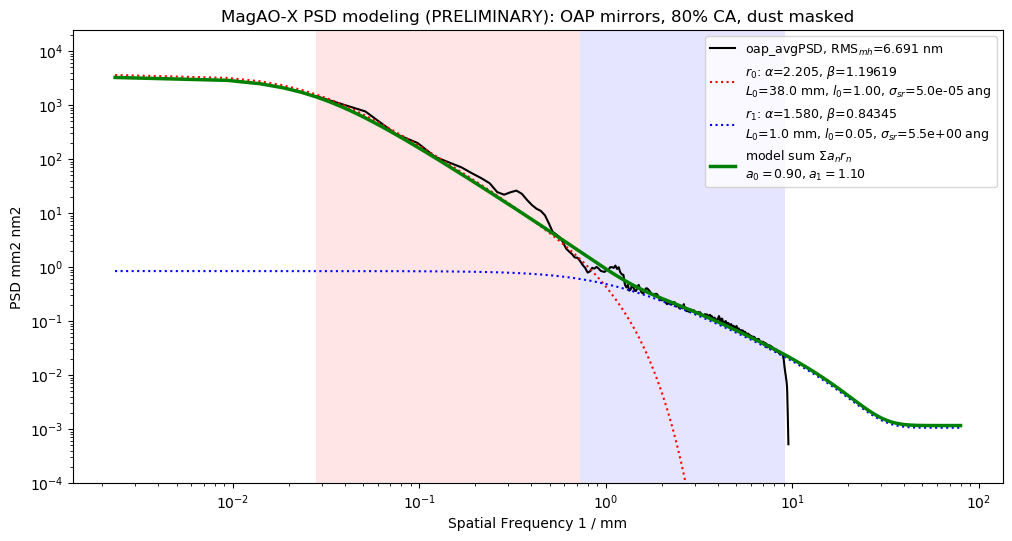

In [12]:
i_start = [0, 30]
i_end = [30, 390]
#i_end = i_start[1:]
#i_end.append(390)

sr_rms = [0.51, 0.54, 1.00, 0.59, 0.5, 0.41, 0.44, 0.43] * u.nm
avg_sr_rms = np.mean(sr_rms)
rms_sr = [0.000005*u.nm, avg_sr_rms]

lo = [1, 0.05]
L0 = [38*u.mm, 1*u.mm]

psd_scl = [[0.9, 1.1]]

mdl_set = []
for j in range(0, len(i_start)):
    mdl = psd.model(region_num=j, ind_start=i_start[j], ind_end=i_end[j],
                k_radial=avg_psd.k_radial, p_radial=avg_psd.psd_radial_cal,
                k_min=avg_psd.k_min, k_max=avg_psd.k_max)
    mdl.solve_lsf()
    mdl.extend_k(delta_k=avg_psd.delta_k, k_limit=80/u.mm)
    mdl.calc_bsr(rms_sr=rms_sr[j])
    mdl.calc_model_full(L0=L0[j], lo=lo[j], k_range=mdl.k_extend)
    mdl_set.append(mdl)

# apply the PSD scaling
mdl_sum = np.zeros((len(psd_scl), len(mdl.psd_full)))
for j in range(0, len(psd_scl)): 
    for js in range(0, len(i_start)):
        mdl_sum[j] = mdl_sum[j] + (mdl_set[js].psd_full.value*psd_scl[j][js])

color_list=['r', 'b','y']
plt.figure(figsize=[12,6], dpi=100)
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS{1}={2:.3f}'.format(avg_psd.surf_name,r'$_{mh}$', avg_psd.rms_mh))
for j in range(0, len(i_start)):
    plt.loglog(mdl_set[j].k_extend.value, mdl_set[j].psd_full.value, color_list[j]+':', linewidth=1.5,
               label='{0}: {1}={2:.3f}, {3}={4:.5f}\n{5}={6:.1f}, {7}={8:.2f}, {9}={10:.1e} ang'.format(r'$r_{0}$'.format(mdl_set[j].region_num), r'$\alpha$', mdl_set[j].alpha, 
                                                                                                    r'$\beta$', mdl_set[j].beta.value, r'$L_{0}$',L0[j], r'$l_{0}$', lo[j], 
                                                                                                    r'$\sigma_{sr}$', rms_sr[j].to(u.angstrom).value))
    plt.axvspan(avg_psd.k_radial[i_start[j]].value, avg_psd.k_radial[i_end[j]].value, facecolor=color_list[j], alpha=0.1)
txt_print = r'$a_{0}={1:.2f}, a_{2}={3:.2f}$'.format(0, psd_scl[0][0], 1, psd_scl[0][1])
plt.loglog(mdl_set[0].k_extend.value, mdl_sum[0], 'g', linewidth=2.5, label='model sum {0}\n{1}'.format(r'$\Sigma a_{n}r_{n}$', txt_print))
plt.ylim(bottom=1e-4)
plt.xlabel('Spatial Frequency {0}'.format(avg_psd.k_radial.unit))
plt.ylabel('PSD {0}'.format(avg_psd.psd_radial_cal.unit))
plt.title('MagAO-X PSD modeling (PRELIMINARY): OAP mirrors, {0}% CA, dust masked'.format(opt_parms['ca']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))